# Defining Virtual Species Characteristics


## How many iterations?

An important consideration for developing virtual species with a cellular automata is how long should the simulation run for? The answer to this may be dependent on the aims of the overall experiment. For example, below we implement a simulation with a static habitat suitability map. As such there is no expectation to observer range expansion, contraction or shitfts. Rather we would expect the species distribution to reach equilibrium, where it consistently occupies a certain range, with random fluctuations due to the extinction and colonisation processes.

As such, we can try to approximately find how many iterations it takes for simulations to reach equilibrium.

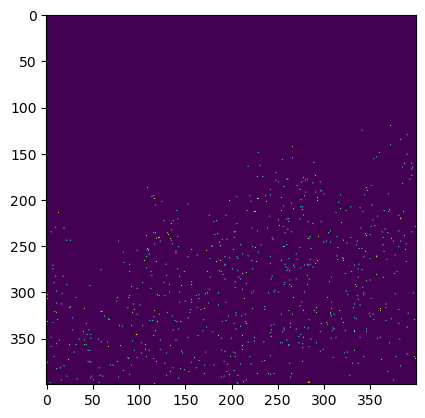

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\Liam\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


PyObject <matplotlib.image.AxesImage object at 0x0000000063191BB0>

In [1]:
include("../../src/SpatialVirtualSpecies.jl")
using .SpatialVirtualSpecies
using DataFrames,DelimitedFiles
using PyPlot

header = SpatialVirtualSpecies.getHeader("../../data/suitability_789.asc",6)
suitability = readdlm("../../data/suitability_789.asc",skipstart=6)
pa = SpatialVirtualSpecies.generateStateLayer(suitability,0.01,(0.4,1.0))
# Create cartesian index 
paIdx = CartesianIndices(suitability)
# Define POS parameter constructors
pos_params = SpatialVirtualSpecies.ExponentialPosSelector(3)
# Define dispersal parameters
cp = SpatialVirtualSpecies.ColoniseParameters(pos_params,0.2)
#Create simulation constructor
ca = SpatialVirtualSpecies.SpeciesCellularAutomata(pa,paIdx,suitability,suitability)
imshow(ca.pa)

In this example we use the prevalence of the species as the metric to define equilibrium. We have defined a function similar to the simulation function defined in the {LINK} example, except we nest the simulation for loop within another loop in order to perform replicate simulations. After each colonise and extinction process within an interation of a simulation we calculate how many cells are occupied and divide by the total number of cells to get the prevalence, then store this in a data frame.


In [2]:
function speciesPrevalenceOverTime(ca,maxIterations,nReps)
    results = DataFrame(rep = String[], timestep = Int64[], nOcc = Float64[])
    for rep in 1:nReps
        for i in 1:maxIterations
            SpatialVirtualSpecies.colonise(ca,cp)
            SpatialVirtualSpecies.extinction(ca)
            prev = sum(ca.pa)/160000
            push!(results,[string(rep) i prev])
        end
        # Reset state layer
        ca.pa = SpatialVirtualSpecies.generateStateLayer(suitability,0.01,(0.,1.0))
    end
    return(results)
end
# Reset occurrence state layer
ca.pa = SpatialVirtualSpecies.generateStateLayer(suitability,0.01,(0.4,1.0))
stabilityTests = speciesPrevalenceOverTime(ca,1000,10)

,rep,timestep,nOcc
,String,Int64,Float64
1,1,1,0.00314375
2,1,2,0.00245
3,1,3,0.0019875
4,1,4,0.001625
5,1,5,0.00136875
6,1,6,0.0011375
7,1,7,0.001075
8,1,8,0.001
9,1,9,0.00094375


We can see that after ~200 iterations the prevalence of the species stabilises and oscilates around a prevalence of ~1.2%. Therefore if we wanted to generate a set of replicate simulation maps, running simulations with 200-250 repetitions should be adequate. Increasing the repetitions in this instance would simply increase computation time unnecessarily.

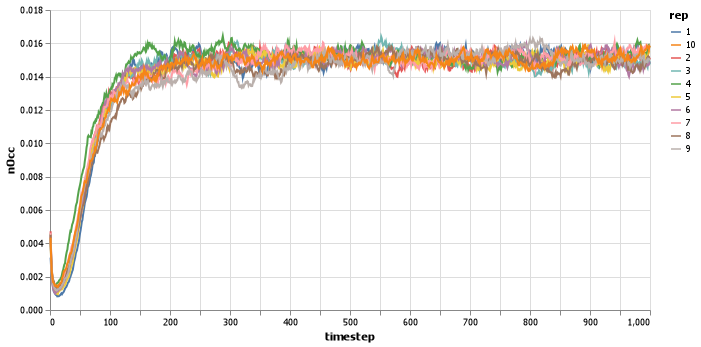

In [3]:
using VegaLite
stabilityTests |> @vlplot(:line,x=:timestep,y=:nOcc,color=:rep,width=600,height=300)

## What dispersal parameters should I choose?

## What neighbourhood parameters should I choose?